# 비콘 메시지의 수신 시간 간격을 활용한 스푸핑 공격 감지

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import Holt

In [2]:
class Confidence():
    def __init__(self, z, holt_z):
        self.z = z  # 2.58, 99%의 신뢰구간
        self.holt_z = holt_z # 3.219, 99.9%의 신뢰구간
    
    # 다음 수신 시간 간격 값을 예측하는데 방해되는 불안정한 데이터 수집 방지
    def confidenceInterval(self, use_INT_arr):
        return np.mean(use_INT_arr) + ( self.z * (np.std(use_INT_arr) / np.sqrt(len(use_INT_arr))) )

    # 예측값을 기반으로 다음 수신 시간 간격의 하한값을 계산
    def holtLower(self, fcast, se):
        return fcast - ( self.holt_z * se )

In [3]:
class HoltMethod():
    def __init__(self, a):
        self.a = a # 0.1
    
    # 다음 수신 시간 간격 값을 예측
    def holtForcast(self, use_INT_arr):
        if len(use_INT_arr) < 10:
            count = 10 - len(use_INT_arr)
            
            for i in range(count):
                use_INT_arr.append(use_INT_arr[i])
                
        fit = Holt(use_INT_arr, initialization_method="estimated").fit(smoothing_level=self.a)
        return fit.forecast(1)[0]

In [4]:
class INT():
    def __init__(self, testCase, mini_range):
        self.use_INT_arr = []
        self.pre_time = 0
        self.fcast = 0
        self.power_sum = 0
        self.se = 0
        self.idx = 2
        self.testCase = testCase
        self.mini_range = mini_range

        self.confi = Confidence(z = 2.58, holt_z= 3.219)
        self.holt = HoltMethod(a = 0.1)

    def full_arr(self):
        del self.use_INT_arr[:len(self.use_INT_arr) - 100]

    def check_INT(self, curr_time, test):
        if len(self.use_INT_arr) > 10000:
            self.full_arr()

        if self.pre_time == 0:
            self.pre_time = curr_time
            return False

        # 수신 시간 간격 계산
        INT = curr_time - self.pre_time

        if len(self.use_INT_arr) < 3 and INT < self.mini_range:
            self.use_INT_arr.append(INT)
            self.pre_time = curr_time
            return False

        # 계산된 수신 시간 간격이 신뢰 구간에 속하는지 검사
        if INT < self.confi.confidenceInterval(self.use_INT_arr):
            if len(self.use_INT_arr) > self.testCase :

                if self.fcast == 0:
                    self.fcast = self.holt.holtForcast(self.use_INT_arr)
                    self.use_INT_arr.append(INT)
                    self.pre_time = curr_time
                    return False
                
                self.power_sum += np.power(INT - self.fcast, 2)

                if self.se == 0:
                    self.se = np.sqrt(self.power_sum / ( self.idx - 1))
                    self.fcast = self.holt.holtForcast(self.use_INT_arr)
                    self.use_INT_arr.append(INT)
                    self.pre_time = curr_time
                    self.idx += 1
                    return False

                fcast_pre = self.fcast
                se_pre = self.se

                self.fcast = self.holt.holtForcast(self.use_INT_arr)
                lower = self.confi.holtLower(self.fcast, self.se)
                self.se = np.sqrt(self.power_sum / ( self.idx - 1))
                self.idx += 1
            
                # 계산된 수신 시간 간격이 예측된 하한값보다 작은지 검사
                # 작다면 스푸핑 공격으로 간주
                if INT < lower and test:
                    self.fcast = fcast_pre
                    self.se = se_pre
                    self.power_sum -= np.power(INT - fcast_pre, 2)
                    self.idx -= 1
                    return True
                
            
            if not test:
                self.use_INT_arr.append(INT)
                
        self.pre_time = curr_time
        return False

In [5]:
res = []
    
for j in range(1, 2701):
    df = pd.read_csv('./data/data' + str(j) + '.csv')

    df_time = df['time']
    case = 5
    mini_range = 0.3
    flag = False

    if len(df_time) > 95:
        case = 10
    elif len(df_time) > 495:
        case = 50
        
    if j >= 901 and j <= 1800:
        mini_range = 0.17
    elif j >= 1801 and j <= 2700:
        mini_range = 0.05
    
    INT_d = INT(case, mini_range)

    for i in range(len(df_time)):
        if i < len(df_time) - 6:
            INT_d.check_INT(df_time[i], False)
        else:
            if not flag:
                int_res = INT_d.check_INT(df_time[i], True)
                
                if int_res:
                    flag = True
            break

    if flag:
        res.append(True)
    else:
        res.append(False)

C:\Users\82109\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\82109\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\82109\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\82109\anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\82109\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
len(res)

2700

In [7]:
print((res.count(True) / len(res)) * 100)

94.88888888888889


In [8]:
"""
case_50: 스푸핑 공격 감지에 사용된 비콘 메시지의 수신 시간 간격 데이터가 50개인 경우
case_100: 스푸핑 공격 감지에 사용된 비콘 메시지의 수신 시간 간격 데이터가 100개인 경우
case_500: 스푸핑 공격 감지에 사용된 비콘 메시지의 수신 시간 간격 데이터가 500개인 경우

case_fast: 비콘 메시지의 평균 수신 시간 간격이 0.04ms인 경우
case_normal: 비콘 메시지의 평균 수신 시간 간격이 0.13ms인 경우
case_slow: 비콘 메시지의 평균 수신 시간 간격이 0.35ms인 경우
"""
case_50 = res[0:300] + res[900:1200] + res[1800:2100]
case_100 = res[300:600] + res[1200:1500] + res[2100:2400]
case_500 = res[600:900] + res[1500:1800] + res[2400:2700]

case_fast = res[1800:2700]
case_normal = res[900:1800]
case_slow = res[0:900]

In [9]:
acc_50 = case_50.count(True)
acc_100 = case_100.count(True)
acc_500 = case_500.count(True)

acc_fast = case_fast.count(True)
acc_normal = case_normal.count(True)
acc_slow = case_slow.count(True)

In [10]:
print(acc_50 / len(case_50) * 100)
print(acc_100 / len(case_100) * 100)
print(acc_500 / len(case_500) * 100)

print(acc_fast / len(case_fast) * 100)
print(acc_normal / len(case_normal) * 100)
print(acc_slow / len(case_slow) * 100)

95.88888888888889
95.55555555555556
93.22222222222221
95.55555555555556
91.66666666666666
97.44444444444444


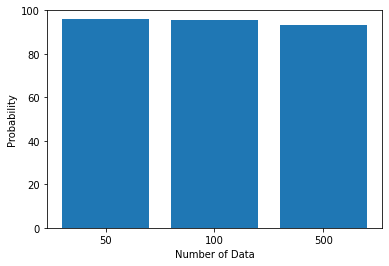

In [11]:
import matplotlib.pyplot as plt

x = np.arange(3)
testCase_num = ['50', '100', '500']
values = [(acc_50 / len(case_50)) * 100, (acc_100 / len(case_100)) * 100, (acc_500 / len(case_500)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Number of Data')
plt.ylabel('Probability')

plt.show()

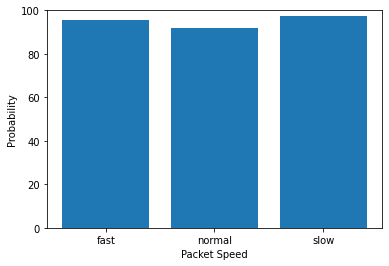

In [12]:
x = np.arange(3)
testCase_num = ['fast', 'normal', 'slow']
values = [(acc_fast / len(case_fast)) * 100, (acc_normal / len(case_normal)) * 100, (acc_slow / len(case_slow)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Packet Speed')
plt.ylabel('Probability')

plt.show()